In [1]:
import torch, torchvision
from torch.optim import lr_scheduler
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [3]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [4]:
numb_batch = 128
training_round = 10

In [5]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

/usagers3/opmos/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
dataloaders_dict = {'train': train_dl, 'val':val_dl}
dataset_sizes = {'train': len(train_dl.dataset.data), 'val': len(val_dl.dataset.data) }
class_names = train_dl.dataset.classes

In [7]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [8]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [9]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [10]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()

    data_file = open('./data/26-10-2021/Train1/pytorch/lenet5/torch_{}_{}_{}.csv'.format(model_name, date, training_round), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])

    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since_1 = time.time()

        # Each epoch has a training and validation phase
        #data_writer.writerow(['Model','type', 'Dataset', 'Train_loss', 'Train_acc', "val_loss", "Val_acc"])
        rows = [model, 'pytorch','mnist','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
        #for phase in ['train', 'val']:
        #for i, data in enumerate(trainloader, 0):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                #inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                   # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print(criterion)
                        loss = criterion(outputs, labels)
                    #outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    #model.bad_variable_used_across_loop.detach() # detach it

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print("      ------",i, running_loss, running_corrects)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            rows.append(phase)
            rows.append('Loss: {:.4f}'.format(epoch_loss))
            rows.append('Acc: {:.4f}'.format(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        time_elapsed_1 = time.time() - since_1
        print()
        rows.append(time.time())
        rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
        data_writer.writerow(rows)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

    data_file.close()
    return model, val_acc_history

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [13]:
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
model = create_lenet().to(device)
num_epochs = 50
model_name = 'lenet5-mnist'
#optimizer = optim.Adam(cnn.parameters(), lr=lr)
optimizer_ft = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)      
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.4565 Acc: 0.8418
val Loss: 0.0945 Acc: 0.9701

Epoch 1/49
----------
train Loss: 0.0772 Acc: 0.9764
val Loss: 0.0692 Acc: 0.9769

Epoch 2/49
----------
train Loss: 0.0570 Acc: 0.9829
val Loss: 0.0593 Acc: 0.9817

Epoch 3/49
----------
train Loss: 0.0446 Acc: 0.9864
val Loss: 0.0612 Acc: 0.9809

Epoch 4/49
----------
train Loss: 0.0358 Acc: 0.9892
val Loss: 0.0559 Acc: 0.9848

Epoch 5/49
----------
train Loss: 0.0292 Acc: 0.9909
val Loss: 0.0659 Acc: 0.9826

Epoch 6/49
----------
train Loss: 0.0254 Acc: 0.9920
val Loss: 0.0561 Acc: 0.9856

Epoch 7/49
----------
train Loss: 0.0146 Acc: 0.9953
val Loss: 0.0343 Acc: 0.9900

Epoch 8/49
----------
train Loss: 0.0100 Acc: 0.9971
val Loss: 0.0340 Acc: 0.9905

Epoch 9/49
----------
train Loss: 0.0084 Acc: 0.9977
val Loss: 0.0345 Acc: 0.9908

Epoch 10/49
----------
train Loss: 0.0073 Acc: 0.9980
val Loss: 0.0351 Acc: 0.9907

Epoch 11/49
----------
train Loss: 0.0065 Acc: 0.9983
val Loss: 0.0357 Acc: 0.9905

Ep

In [14]:
torch.save(model_ft, './data/26-10-2021/Train1/pytorch/lenet5/torch_{}_{}_{}.pth'.format(model_name, date, training_round))

Saving Best Model with Accuracy:  93.08999633789062
Epoch: 1 Accuracy : 93.08999633789062 %
Saving Best Model with Accuracy:  96.81999969482422
Epoch: 2 Accuracy : 96.81999969482422 %
Saving Best Model with Accuracy:  97.66000366210938
Epoch: 3 Accuracy : 97.66000366210938 %
Saving Best Model with Accuracy:  98.12000274658203
Epoch: 4 Accuracy : 98.12000274658203 %
Saving Best Model with Accuracy:  98.29000091552734
Epoch: 5 Accuracy : 98.29000091552734 %
Saving Best Model with Accuracy:  98.4800033569336
Epoch: 6 Accuracy : 98.4800033569336 %
Saving Best Model with Accuracy:  98.58999633789062
Epoch: 7 Accuracy : 98.58999633789062 %
Epoch: 8 Accuracy : 98.5199966430664 %
Epoch: 9 Accuracy : 98.58000183105469 %
Epoch: 10 Accuracy : 98.47000122070312 %


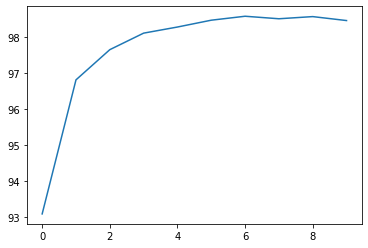

In [15]:
lenet = train(10, device=device)

In [16]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [17]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [16]:
#y_pred, y_true = predict_dl(model_ft, )